In [1]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import t 
import seaborn as sns
import matplotlib.patches  as patches
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower
from collections import namedtuple
sns.set_style('whitegrid')
random.seed(30)
np.random.seed(30)
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (12.5, 9),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# Normality Assumption

- We have the assumption that the distribution of the means $\Delta$ follows a normal distribution. 

## Why is it important?
- We have the assumption that the distribution of the means follows a normal distribution. This is a strong assumption to have and needs to be tested/ensured before further methods. Why is that so? Well, a 1.96 * Standard error estimates the population to be within 95% confidence interval in a normal distribution.

For example, let us consider an event where we are interested in knowing what is in the 5% of a probability distribution and we assume our distribution to be normal when it is not. You can clearly observe from the plot below that the areas under the curve are vastly different. __Any statistic we would calculate under the assumption would be wrong__

In [2]:
def compare_plot(df,alpha):
    critical_value = stats.t.ppf(1.0 - alpha, df)
    f, ax = plt.subplots(1)
    ax.set_ylim(bottom=0,top=0.41)
    x = np.linspace(stats.t.ppf(0.01, df),
                    stats.t.ppf(0.99, df), 100)
    plt.plot(x, stats.t.pdf(x, df), color = 'r', label =f'$t-distribution$ with df 3 (not normal)')
    plt.fill_between(x=np.arange(-4.54,-critical_value,0.01),
                     y1= t.pdf(np.arange(-4.54,-critical_value,0.01), df),
                        facecolor='r',
                        alpha=0.5)     
    plt.text(x=(-critical_value-4.54)/1.7, y=0.04, color='red',size='large', s= f'$Area = {alpha}$')
    # plotting standard normal distribution
    x_axis = np.arange(-4, 4, 0.01)
    plt.plot(x_axis, stats.norm.pdf(x_axis,0,1), color ='b', label = f'$z- distribution$ (normal)')
    
    plt.fill_between(x=np.arange(-4,-critical_value,0.01), 
                y1= stats.norm.pdf(np.arange(-4,-critical_value,0.01)),
                facecolor='b',
                alpha=0.5)
    plt.axvline(x=-critical_value, color = "black", alpha=0.5,linestyle='--')
    plt.text(x=-critical_value, y=0.04, size='large',color='b', s= f'$Area = {round(stats.norm.cdf(-critical_value),3)}$')
    plt.legend()
    plt.title('Error due to incorrect Assumption of Normal Distribution')

__If we would have assumed our 't-distribution with 3 df' to be normal and had applied normal distribution formula to it to obtain the area of the curve (here, p-value), it would have been 0.061 or 6.1%. However, The true area would have been 0.11 which is 11%. Our calculation in the area would have been off by 4.9% which is a significant error and any inference that would follow would have serious flaw in it__ 

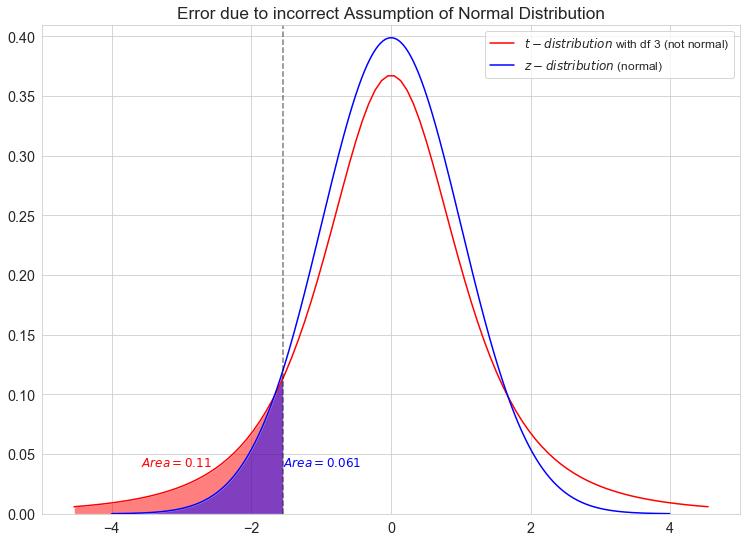

In [3]:
compare_plot(3,0.11)

## Tests for Normality:

There are three common method sof checking for normality:
- __Graphical Methods :__ 
Easiest way to visually assess if there is normalitity. Histogram, box-plot and stem-and-leaf plot are the common ones.

- __Numerical Methods :__
Numerical methods include skewness and kurtosis coefficients.

- __Normality Tests :__
Inlcude more formal methods done with statistical inferences.

I am going to use these three distributions as the basis for this notebook.
These are sampled accordingly
- __data1:__ normal distribution
- __data2:__ gamma distribution with shape 1.1
- __data3:__ uniform distribution 

In [4]:
#generate data

#from normal dist
data1 = np.array([np.random.normal() for _ in range(1000)])

#from gamma dist with 1.1 scale 
data2 = np.array([np.random.gamma(1.1) for _ in range(1000)])

#from uniform dist 
data3 = np.array([np.random.uniform() for _ in range(1000)])

## Graphical methods:

### 1) Histogram plot

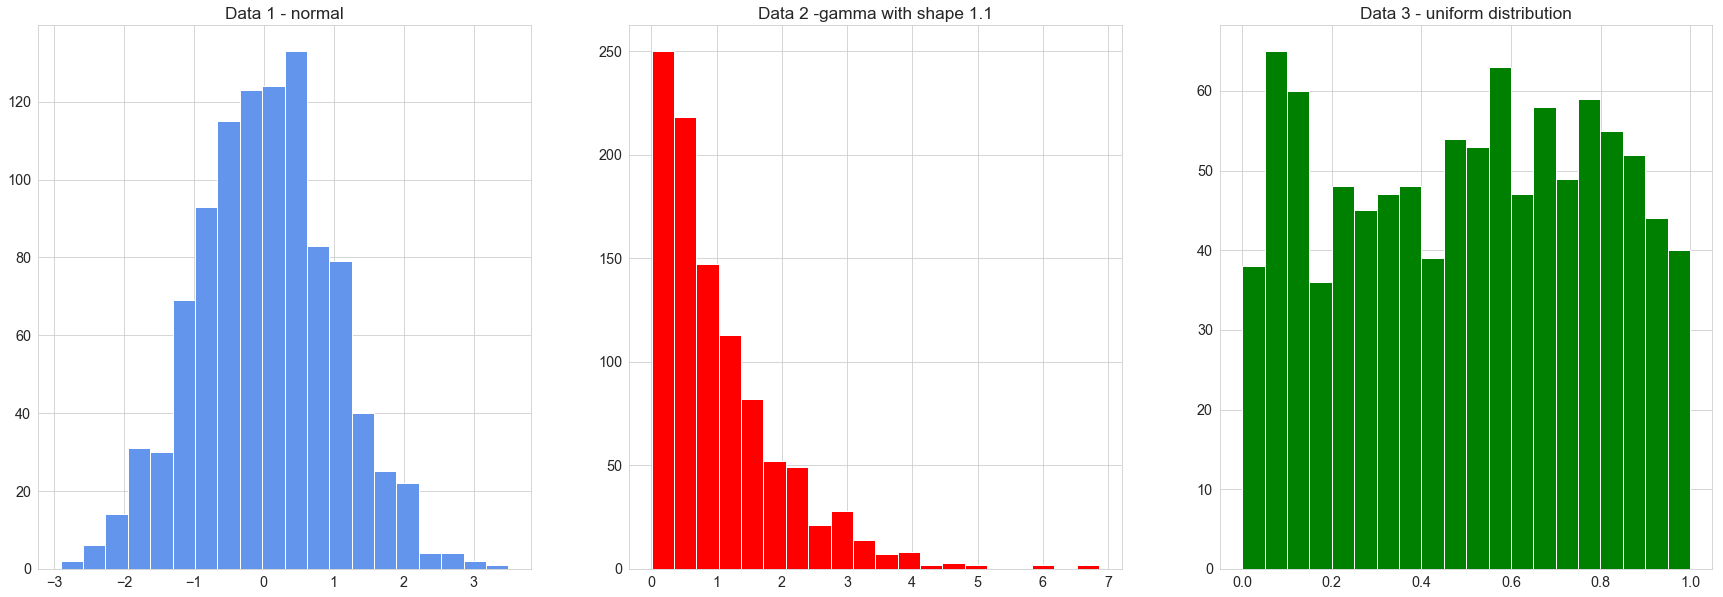

In [5]:
bins = 20
fig = plt.figure(figsize=(30, 10))
ax1 = plt.subplot(1, 3, 1)
plt.hist(data1, bins = bins, color='cornflowerblue')
plt.title('Data 1 - normal')
ax2 = plt.subplot(1, 3, 2)
plt.hist(data2, bins = bins, color='red')
plt.title('Data 2 -gamma with shape 1.1')
ax2 = plt.subplot(1, 3, 3)
plt.hist(data3, bins = bins, color ='green')
plt.title('Data 3 - uniform distribution')
plt.show()

### 2) Box plots: 
A boxplot has the following elements:

- Minimum : the lowest data point excluding any outliers.
- Maximum : the largest data point excluding any outliers.
- Median (Q2 / 50th percentile) : the middle value of the dataset.
- First quartile (Q1 / 25th percentile) : also known as the lower quartile qn(0.25), is the median of the lower half of the dataset.
- Third quartile (Q3 / 75th percentile) : also known as the upper quartile qn(0.75), is the median of the upper half of the dataset
- Outliers: (shown as green circles)

<div>
    <center>
    <img src="images/fig-3.png" width="500"/>
        <br>
     <text><b> Fig 1: Ideal boxplot and probability density function for a normal distribution</b> <br> 
         <i> (Source: https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51)</i>
     </text>
    </center>
</div>


Text(0.5, 1.0, 'Violin Plots for the data distribution (combination of box plots and kde plots)')

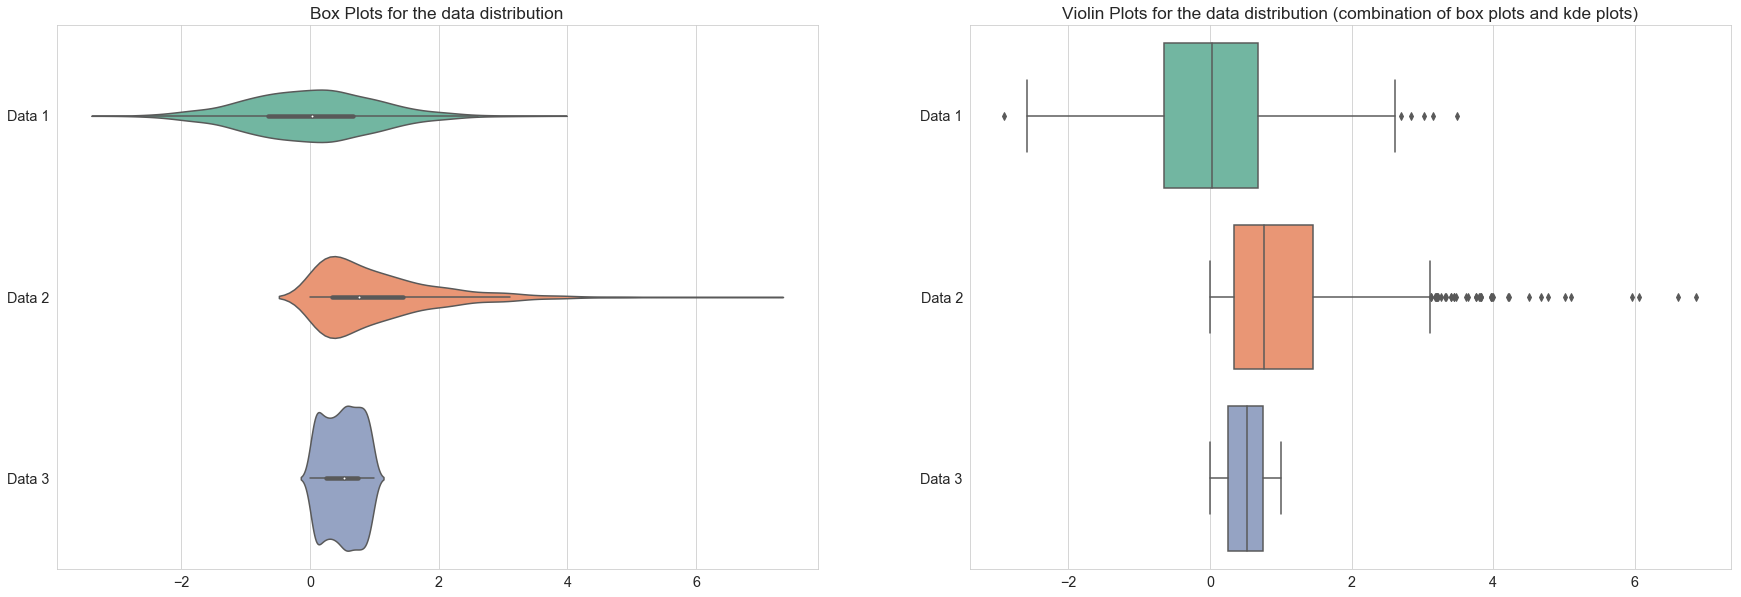

In [6]:
fig = plt.figure(figsize=(30, 10))

ax1 = plt.subplot(1, 2, 1)
ax1 = sns.violinplot(data=[data1,data2,data3], orient="h", palette="Set2")
ax1.set_yticklabels(['Data 1','Data 2','Data 3'])
ax1.set_title('Box Plots for the data distribution')


ax2 = plt.subplot(1, 2, 2)
ax2 = sns.boxplot(data=[data1,data2,data3], orient="h", palette="Set2")
ax2.set_yticklabels(['Data 1','Data 2','Data 3'])
ax2.set_title('Violin Plots for the data distribution (combination of box plots and kde plots)')


### 3) Q-Q Plots:

Quantile plot is a grpahical tool to assess if the set of data came from a desired distribution. It is a scatterplot created by two sets of quantiles against one other. If both sets of quantiles came from the same distribution, we would see the points forming a line that is roughly straight. For Normal distribution, with a mean of 0. The 0.5 quantile, or 50th percentile, is 0. Half the data lie below 0. The 0.95 quantile, or 95th percentile, is about 1.64. Similarly, 95 percent of the data lie below 1.64. 
__We are comparing theoretical 'ideal normal distribution quantiles' with the observed one. If they line up, we have a normal distribution.  If our data adheres to the theorized distribution, it will follow the standardized line__

___Note: In the KDE plot below, The y-axis in a density plot is the probability density function for the kernel density estimation. However, we need to be careful to specify this is a probability density and not a probability. The difference is the probability density is the probability per unit on the x-axis. To convert to an actual probability, we need to find the area under the curve for a specific interval on the x-axis.___ -https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0

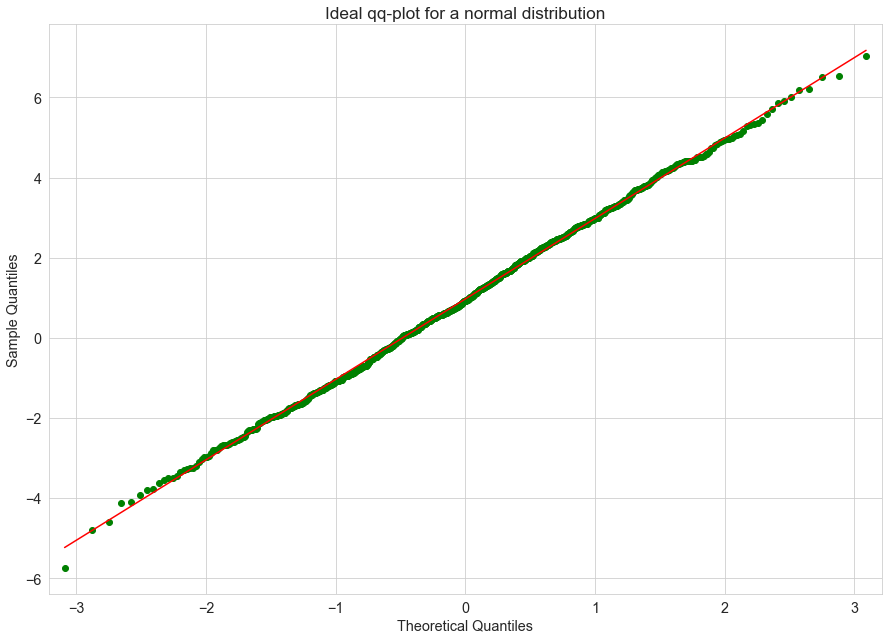

In [7]:
sm.qqplot(np.random.normal(1,2,1000),color='green',line='s')
plt.title('Ideal qq-plot for a normal distribution')
plt.tight_layout()

In [8]:
def qqPlot():
    pp = sm.ProbPlot(np.array(x4), fit=True)
    qq = pp.qqplot(marker='.', markerfacecolor='red', markeredgecolor='k')
    sm.qqline(qq.axes[0], line='45', fmt='k--')

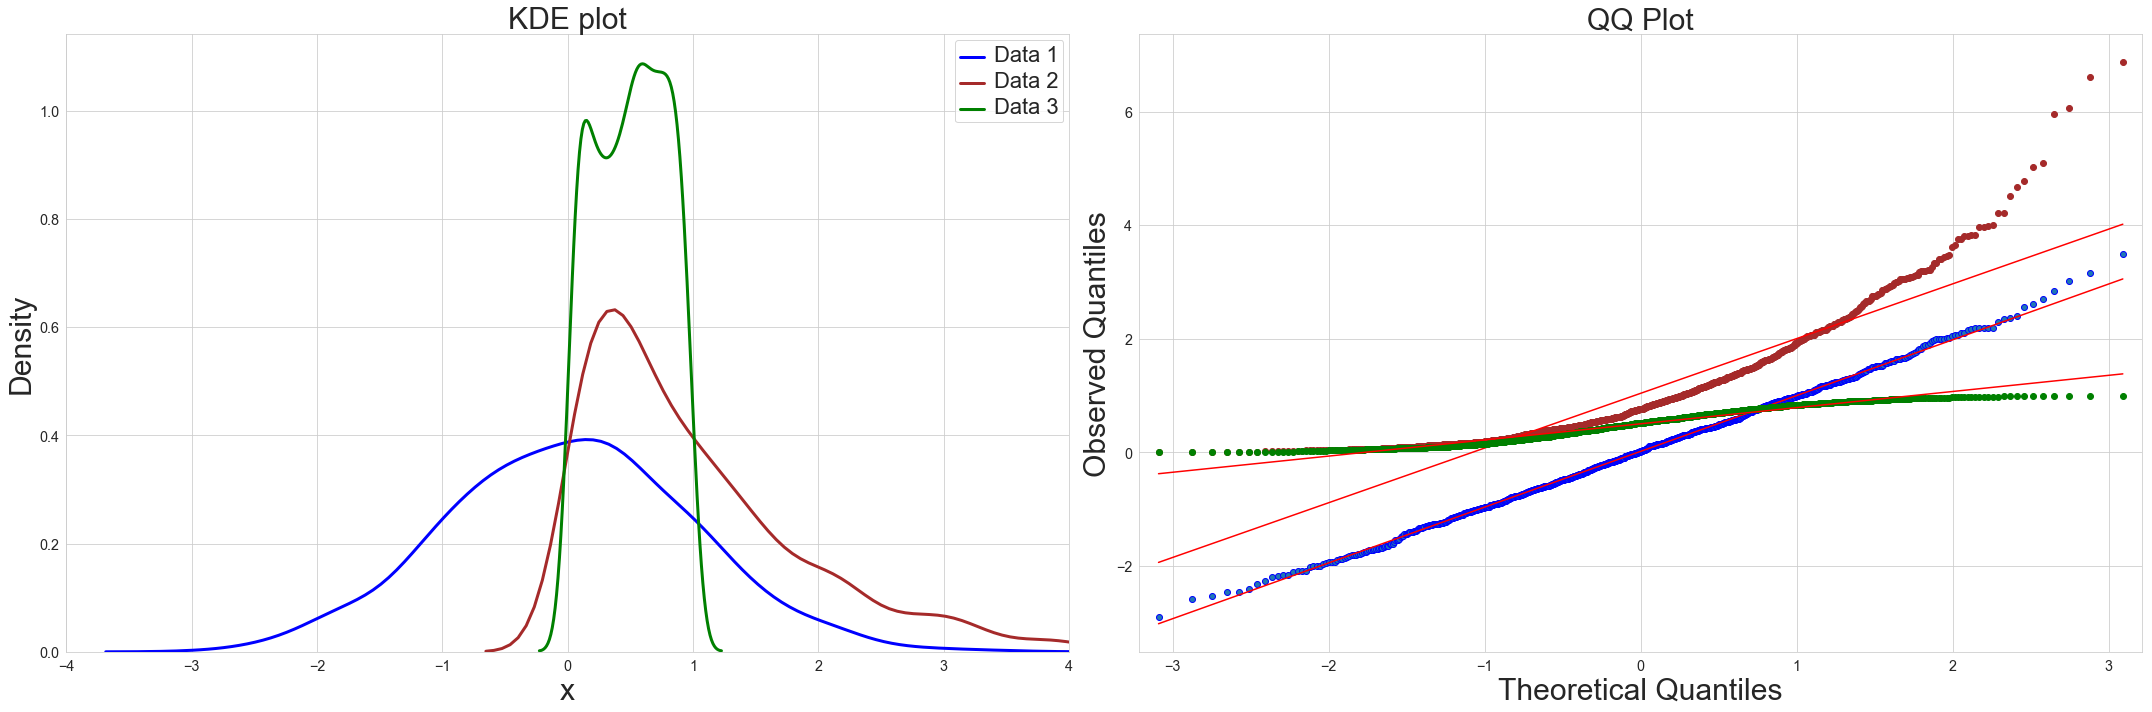

In [9]:
fig = plt.figure(figsize=(30, 10))
ax1 = plt.subplot(1, 2, 1)
ax1.set_title('KDE plot', fontsize=30)
ax1.set_ylabel('Density', fontsize=30)
ax1.set_xlabel('x', fontsize=30)
ax1.set_xlim(left=-4,right=4)
sns.distplot(data1,hist=False ,kde_kws={"color": "blue", "lw": 3}, label='Data 1')
sns.distplot(data2,hist=False, kde_kws={"color": "brown", "lw": 3}, label='Data 2')
sns.distplot(data3 ,hist=False, kde_kws={"color": "green", "lw": 3},label='Data 3')
plt.setp(ax1.get_legend().get_texts(), fontsize='22')
ax2 = plt.subplot(1, 2, 2)
sm.qqplot(data1,ax=ax2,color='blue',line='s')
sm.qqplot(data2,ax=ax2,color='brown',line='s')
sm.qqplot(data3,ax=ax2,color='green',line='s')
ax2.get_lines()[0].set_markerfacecolor('C0')
ax2.set_title('QQ Plot', fontsize=30)
ax2.set_ylabel('Observed Quantiles', fontsize=30)
ax2.set_xlabel('Theoretical Quantiles', fontsize=30)

plt.subplots_adjust(hspace = 200)
plt.tight_layout()

In [10]:
%%HTML
<style>
td {
  font-size: 20px
}
</style>

## Numerical methods:

### 1) Skewness:
Skewness is a measure of the asymmetry of the probability distrbution of a random variable about its mean. It tells us the amount and direction of departure from horizontal symmetry. If skewness is 0, the data are perfetcly symmetrical. If the skewness is negative, then the distribution is skewed to the left, while if the skew is positive then the distribution is skewed to the right 
Generally,
- If skewness is less than -1 or greater than 1, the distribution is highly skewed.
- If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.
- If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.


Intuitively, The greater the skew, the greater the distance betweren mode, median and the mean 
- For postiive skew: mode < median < mean
- For negative skew: mean < median < mode

__The skewness for a normal distribution is zero, and any symmetric data should have a skewness near zero.__


### 2) Kurtosis: 
measures the peakedness or flatness of a distribution.
Positive kurtosis indicates a thin pointed distribution.
Negative kurtosis indicates a broad flat distribution.

__The Kurtosis for a for a normal distribution would be close to 0.__



### Moment based calculation:
Moments of a function are quantitative measures related to the shape of the function's graph. In statistics, 
Moments are a set of statistical parameters to measure a distribution
Without much detail, First moment of any distribution is the mean, second is the variance, third is the skewness and fourth is the kurtosis .


| Moment Order | Statistic |<div style="width:190px">Population</div>| <div style="width:340px">Sampling adjustment</div> |
| :--- | :--- | :--- | :--- |
| 1 | Mean : $\mu$ | $\frac{\sum x}{n}$ | Same |
| 2 | Standard Deviation : $\sigma$  | $\frac{\sum (x - \mu )^{2}}{n}$| $\frac{\sum (x - \bar{x} )^{2}}{n-1}$ |
| 3 | Skewness : $\Sigma$ | $\frac{1}{n}\frac{\sum (x - \mu )^{3}}{\sigma^{3}}$ | $\frac{n}{(n-1)(n-2)}\frac{\sum (x - \bar{x} )^{3}}{s^{3}}$ |
| 4 | Kurtosis : $\ K$ | $\frac{1}{n}\frac{\sum (x - \mu )^{4}}{\sigma^{4}}$ | $\frac{n(n+1)}{(n-1)(n-2)(n-3)}\frac{\sum (x - \bar{x} )^{4}}{s^{4}}-\frac{3(n-1)^{2}}{(n-2)(n-3)}$|



In [11]:
def skew_kurtosis(data):
    n = len(data)
    mu = np.mean(data)
    std = np.std(data)
    skew= n/((n-1)*(n-2)) * np.sum((data-mu)**3)/std**3
    kurtosis = n*(n+1)/((n-1)*(n-2)*(n-3)) * np.sum((data-mu)**4)/std**4 -  3*(n-1)**2/((n-2)*(n-3))
    return skew,kurtosis

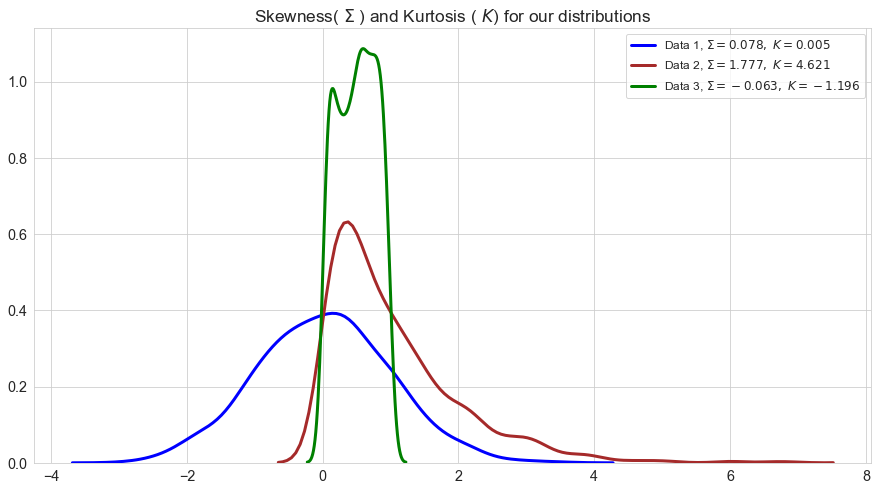

In [12]:
skew1,kurtosis1 = skew_kurtosis(data1)
skew2,kurtosis2 = skew_kurtosis(data2)
skew3,kurtosis3 = skew_kurtosis(data3)

fig = plt.figure(figsize=(15, 8))

sns.distplot(data1,hist=False ,kde_kws={"color": "blue", "lw": 3}, 
             label=f'Data 1, $\Sigma = {round(skew1,3)}, \ K = {round(kurtosis1,3)}$')
sns.distplot(data2,hist=False, kde_kws={"color": "brown", "lw": 3}, 
            label=f'Data 2, $\Sigma = {round(skew2,3)}, \ K = {round(kurtosis2,3)}$')
sns.distplot(data3 ,hist=False, kde_kws={"color": "green", "lw": 3},
            label=f'Data 3, $\Sigma = {round(skew3,3)}, \ K = {round(kurtosis3,3)}$')

plt.title(f'Skewness( $\Sigma$ ) and Kurtosis ($\ K $) for our distributions')
plt.show()

## Normality Tests

### 1) Empericial Distribution Function (EDF) tets:

_Empirical Distribution Function : The EDF is calculated by ordering all of the unique observations in the data sample and calculating the cumulative probability for each as the number of observations less than or equal to a given observation divided by the total number of observations. t's an estimate of the population cdf based on the sample; specifically if you treat the proportions of the sample at each distinct data value and treat it like it was a probability in the population, you get the ECDF.
Simply put, Empirical cumulative distribution function is a cumulative sum of frequencies of observed $x_{i}$ divided by total sample size_

__The distinction is which probability measure is used. For the empirical CDF, you use the probability measure defined by the frequency counts in an empirical sample.__

__The empirical CDF is built from an actual data set. (rank of the ordered x values divided by the total number of values in the distribution). The CDF is a theoretical construct - it is what you would see if you could take infinitely many samples.__

These tests check for the normality of the data by comparing the Empirical Distribution Function (EDF) of the observed data with the cumulative distribution function (CDF) of a normal distrubtion to see if there is a good agreement between them. 



The most famous ones are:
- Kolmogorov-Smirnov Test:
- Lilliefors Test
- Anderson-Darling Test

In the graph below, we can see that the sample we drew out the normal distribution most closely resembles the ideal CDF.

#### a) Kolmogorov-Smirnov Test:
Measures the largest distance between the EDF and the theoritical function. If the difference is larger than the critical-value for the KS statistic, you reject the null hypothesis. Where,

<font size='4'>$T = sup_{x}\left | F^{*}(x) - F_{n}(x) \right |$ <font> <br>
where, $sup_{x}$ stands for suprenum (greatest), $F^{*}(x)$ is the hypothesized distribution function (contextually a normal distribution) and $F_{n}(x)$ is the EDF estimated based on the random sample (our observed data).
The KS test of normality,  $F^{*}(x)$ is taken to be a normal distribution with known mean, $\mu$ and standard deviation $\sigma$ . 

The KS test statistic is meant for testing:

$H_{0} = F^{*}(x) = F_{n}(x)$ for all x from $- \infty$ to $\infty$ (Contextually, The data follows a uniform distribution) <br>
$H_{A} = F^{*}(x) \neq F_{n}(x)$ for all x from $- \infty to \infty$ for atleast one value of x  (Contextually, The data does not follow a uniform distribution)


for KS test statistic: _http://www.real-statistics.com/statistics-tables/kolmogorov-smirnov-table/_

In [13]:
#KS test for data with len >= 50
'''
KS_result = namedtuple('KS_result', ('statistic',
                                               'p_value',
                                               'significance_level'))
                                               
'''

def KS(data, plot=False):
    """
    args : data as an array
    returns : returns the result of the KS test 
    """
    assert len(data) >= 50, 'for this example, provide data with length > 50'
    data = np.sort(data)
    #from ks_crit table for alpha 0.05, and len(data) >=50, 
    ks_crit = 1.35810/np.sqrt(len(data))
    #edf
    edf_data =  np.arange(len(data)) / len(data)
    #null
    cdf_null = [stats.norm.cdf(x) for x in data]

    #two-tailed-test
    diff = max(np.abs(cdf_null - edf_data))
    
    if diff > ks_crit:

        text = 'Reject Null : t-crit: {:.3f} >  max difference: {:.3f}'.format(ks_crit, diff )
    else:
        text = 'Fail to Reject Null  t-crit: {:.3f} < max difference: {:.3f}'.format(ks_crit, diff )
        
    if plot:
        plt.plot(data, edf_data, c = 'red', label='Observed EDF')
        plt.plot(data, cdf_null, c='green', label='Expected CDF')
        plt.fill_between(data, edf_data,cdf_null, alpha = .5, label='Difference')
        plt.legend()
        plt.title(text)
            
    else:
        print(text)
    
   # return KS_result(ks_crit,)
        
    
    

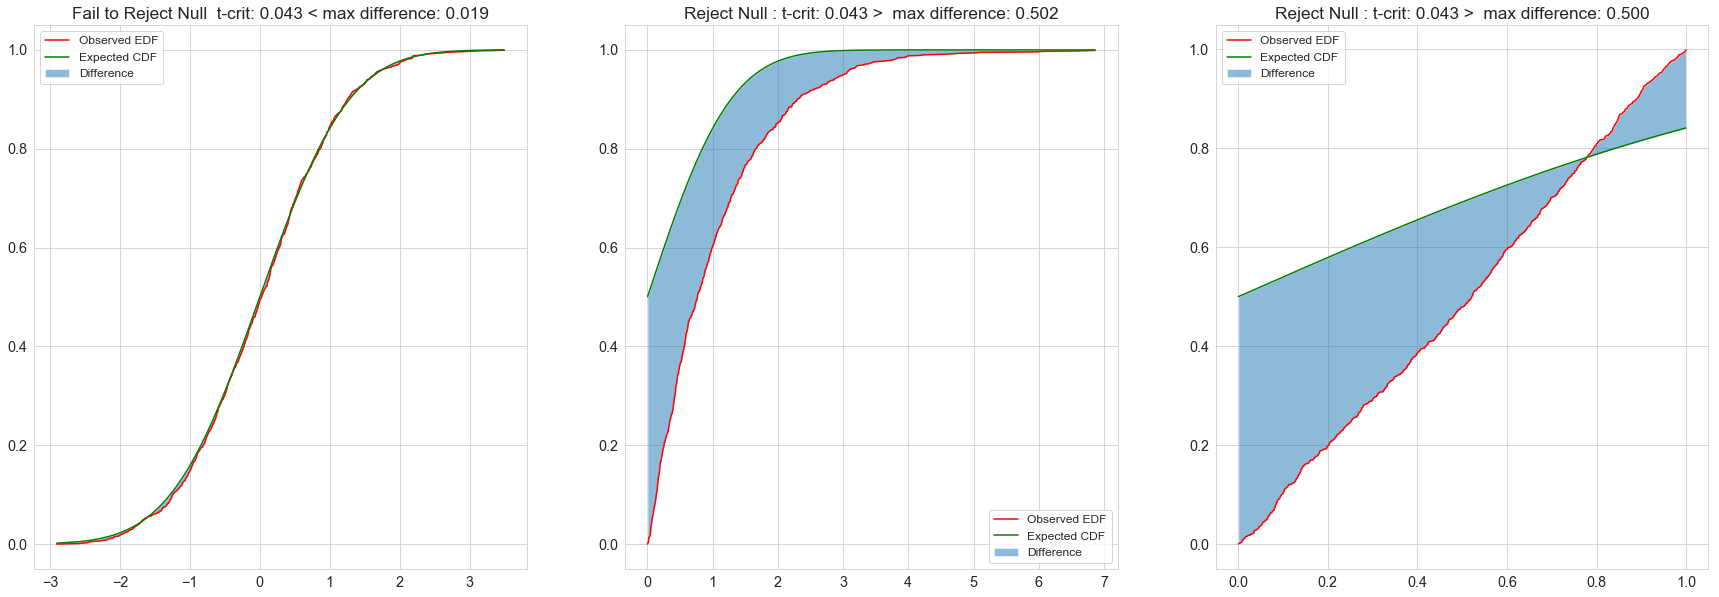

In [14]:
fig = plt.figure(figsize=(30, 10))
ax1 = plt.subplot(1, 3, 1)
KS(data1, plot=True)
ax2 = plt.subplot(1, 3, 2)
KS(data2, plot=True)
ax2 = plt.subplot(1, 3, 3)
KS(data3, plot=True)

#### b) Lilliefors Test:
It is the modificiation of the KS test. KS test is ideal for situations where the parameters of the hypothesized distribution are completely known. In contrast, the parameters for LF test are estimated based on the sample. It uses the same calculations as the KS test but the critical values are smaller, hence is less likely to show that data is normally distributed. In this case, Kolmogorov-Smirnov test based on the critical values in the Kolmogorov-Smirnov Table yields results that are too conservative. 

The Lilliefors test statistic are smaller so are less prone to type 1 errors.

$F^{*}(x)$ is taken to be a normal distribution with known mean, $\mu = \bar{X}$, the sample mean and standard deviation $s^{2}$ the sample variance. 

for Lilliefors test statistic: http://www.real-statistics.com/statistics-tables/lilliefors-test-table/


#### c) Anderson-Darling Test:

Anderson-Darling (AD) test is the most powerful EDF tests belongs to the quadratic class of the EDF statistic which is based on the squared difference. It is a modification of the Kolmogorov-Smirnov (K-S) test and gives more weight to the tails than does the K-S test hence increasing the sensitivity (true positive rate). This lowers the type 2 error (failing to reject the null hypothesis when the null hypothesis is false) . 

__Unlike KS test, the AD test is more concerned with the tails, (which would would be more of a concern of more extreme tails for example, risk mitigation)__



<font size=4>$(F^{*}(x) - F_{n}(x))^{2}$<font>

A modified form of the equation is commonly adapted by D'Agnosti

<font size=4>$A^{{*2}}=A^{2}\left(1+{\frac  {0.75}{n}}+{\frac  {2.25}{n^{2}}}\right).$<font>
   
Normality is rejected if $A^{{*2}}$ exceeds 0.631, 0.752, 0.873, 1.034 or 1.159 at 10%, 5%, 2.5%, 1% and 0.5% significance levels, and the procedure is valid for sample sizes with atleast 8 data points. 

http://www.real-statistics.com/non-parametric-tests/goodness-of-fit-tests/anderson-darling-test/




<font size=4>$A^{2}=-n-{\frac  {1}{n}}\sum _{{i=1}}^{n}(2i-1)(\ln \Phi (Y_{i})+\ln(1-\Phi (Y_{{n+1-i}}))).$<font>

In [15]:


def anderson_test(x):
    
    '''
    args: distribution with len (x) > 8
    returns: returns the ad_statistic and the result at alpha levels (0.1,0.05,0.25,0.01,0.005)
    '''
    
    assert len(x) >= 8, "please have data size larger than 8'"
    x = np.sort(x)
    N = len(x)     
    xbar,s = np.mean(x),np.std(x, ddof=1) #sample metrics
    w = (x - xbar) / s
    
    cdf = np.log(norm.cdf(w))
    sf = np.log(1-norm.cdf(w)) #survival  #or norm.ppf(w)
    #ranks
    i = np.arange(1, N + 1)
 
    # A2 = -N - S where S = weighted difference between theoretical distribution and reverse theoretical distribution
    A2 = -N - np.sum((2*i - 1.0) / N * (cdf + sf[::-1]))
    
   # plt.plot(cdf, label='CDF of the distribution')
   # plt.plot(sf[::-1])
    ad_statistic = A2 * (1 + 0.75/N + 2.25/N**2)   
    sig_levels = [0.1,0.05,0.25,0.01,0.005]
    thresholds =[0.631, 0.752, 0.873, 1.034,1.159]
    reference = dict(zip(sig_levels,thresholds))
 
    for sig_level, threshold in reference.items():
        if ad_statistic > threshold:
            print(f'Reject Null hypothesis at alpha = {sig_level}, AD-Statistic = {round(ad_statistic,3)} > Threshold {threshold}')
        else:
            print(f'Fail to Reject Null hypothesis at alpha = {sig_level}, AD-Statistic = {round(ad_statistic,3)} < Threshold {threshold}')
        
    return ad_statistic


In [16]:
print('data1 results: ')
ad_statistic1 = anderson_test(data1)

print('data2 results: ')
ad_statistic2 = anderson_test(data2)

print('data3 results: ')
ad_statistic3 = anderson_test(data3)

data1 results: 
Fail to Reject Null hypothesis at alpha = 0.1, AD-Statistic = 0.16 < Threshold 0.631
Fail to Reject Null hypothesis at alpha = 0.05, AD-Statistic = 0.16 < Threshold 0.752
Fail to Reject Null hypothesis at alpha = 0.25, AD-Statistic = 0.16 < Threshold 0.873
Fail to Reject Null hypothesis at alpha = 0.01, AD-Statistic = 0.16 < Threshold 1.034
Fail to Reject Null hypothesis at alpha = 0.005, AD-Statistic = 0.16 < Threshold 1.159
data2 results: 
Reject Null hypothesis at alpha = 0.1, AD-Statistic = 38.595 > Threshold 0.631
Reject Null hypothesis at alpha = 0.05, AD-Statistic = 38.595 > Threshold 0.752
Reject Null hypothesis at alpha = 0.25, AD-Statistic = 38.595 > Threshold 0.873
Reject Null hypothesis at alpha = 0.01, AD-Statistic = 38.595 > Threshold 1.034
Reject Null hypothesis at alpha = 0.005, AD-Statistic = 38.595 > Threshold 1.159
data3 results: 
Reject Null hypothesis at alpha = 0.1, AD-Statistic = 11.662 > Threshold 0.631
Reject Null hypothesis at alpha = 0.05, AD-


### 2) Regression and Correlation tests:
These are based on the ratio of two weighted least-quares estimate of scale obtained from other order statistics. The two estimates are the normally distributed weighted least quares estimates and the sample variance from other population.

The most famous one is :
- Shapiro-Wilk Test

#### a) Shapiro-Wilk Test:
This test was the first test that was able to detect departures from normality due to either skewness or kurtosis, or both. It has become the preferred test because of its good power properties. 

<font size=4>${\displaystyle W={\left(\sum _{i=1}^{n}a_{i}y_{(i)}\right)^{2} \over \sum _{i=1}^{n}(y_{i}-{\overline {y}})^{2}},}$ </font>
    
 #the denominator is the sum of squared errors $SS$, <br>
 
where, 
<font size=3>$y_{{(i)}}$ is the $i^{th}$ order statistic (the $i^{th}$-smallest number in the sample) <br>
$ \overline {y}$ = sample mean, <br>
${\displaystyle (a_{1},\dots ,a_{n})={m^{\mathsf {T}}V^{-1} \over C},}$   
${\displaystyle C=(m^{\mathsf {T}}V^{-1}V^{-1}m)^{1/2}}$, <br>
$m=(m_{1},\dots ,m_{n})^{{{\mathsf  {T}}}}$, </font>   are expected values of the order statistics of independent and identically distributed random variables sampled from the standard normal dsitrubtion and $V$ is the covariance matrix of those statistics.

The Shapiro-Wilk test was originally limited to sample size less than 50. But, many iterations of reforms later it is suitable for usage for any $n$ in range $3 \leq n \leq 5000$ [approximation algorithm AS R94 (Royston, 1995) ](https://link.springer.com/article/10.1007%2FBF01891203)

__Note: 0 < $W$ < 1. Small values of W are evidence of departure from normality__

Alternatively, 
Simpl

<font size =5>$W = \frac{b^{2}}{SS}$</font>

where $b$ is the numerator from the above equation and $SS$ is simply the sum of squared errors.

-------------

# AS r94 algorithm: 

__This was implemented to accomodate sizes of 12 to 5000.__

Pseudocode: <br>

The following version of the Shapiro-Wilk Test handles samples between 12 and 5,000 elements.

- Sort the data in ascending order $x_{1}, \leq ......   \leq  x_{n}$
- Define the values $M_{1},.... M_{n}$, by , quantile_function of  $\frac{i-0.375}{n+0.25}$
- find $m = \sum_{i=1}^{n}*M_{i}^{2}$
- Set $u = \frac{1}{\sqrt{n}}$ and define the coefficients $a_{1},.... a_{n}$, <br>
where, <br>
$a_{n} = -2.706056u^{5} + 4.434685u^{4} - 2.071190u^{3} - 0.147981u^{2} + 0.221157u + m_{n}m^{-0.5} $
$a_{n-1} = -3.582633u^{5} + 5.682633u^{4} - 1.752461u^{3} - 0.293762u^{2} + 0.042981u + m_{n-1}m^{-0.5} $
and, <br>
$a_{i} = \frac{m_{i}}{\sqrt{\varepsilon }}$ for 2 < i < n - 1,
$a_{2} = -a_{n-1}$, and $a_{1} = -a_{n}$
where, 
$\varepsilon = \frac{  m - 2m_{n}^{2}   - 2m_{n-1}^{2} }{ 1 - 2a_{n}^{2}   - 2a_{n-1}^{2} }$

  Interestingly, $a_{i} = -a_{n-i+1}$

- And, we have all the variables needed for. 

  <font size=4>${\displaystyle W={\left(\sum _{i=1}^{n}a_{i}y_{(i)}\right)^{2} \over \sum _{i=1}^{n}(y_{i}-{\overline       {y}})^{2}},}$ </font>

- Amazingly, the statistic $ln(1-W)$ , is approximately normally distribution with, <br>
  mean , $\mu = 0.0038915(lnn)^{3} - 0.083751(lnn)^{2} - 0.31082lnn - 0.5861$ and <br>
  std, $\sigma = e^{0.0030302(lnn)^{3}-0.082676lnn - 0.4803}$

- Finally, we can get the test statistic using the standard normal distribution:
  $z = \frac{ln(1-W)-\mu}{\sigma}$
  
- If the p-value $\leq \alpha$, we reject the null hypothesis that the data is normally distributed.



In [17]:
#Royston's Algorithm
shapiro_result = namedtuple('shapiro_result', ('statistic',
                                               'p_value',
                                               'significance_level',
                                              'result'))
def extended_shapiro(data):
    assert len(data) >= 12 and len(data) < 5000, "please have data size larger than 12 and less than 5000'"
    data = np.sort(np.array(data))
    
    #inverse of the cummulative standarized normal distribution.
    N = len(data)
    i = np.arange(1, N+1)
    
    M = norm.ppf((i-.375)/(N +.25))
    m = np.sum(np.square(M))
    
    a = np.empty(shape=(N,))
    u = 1/np.sqrt(N)
    
    a[N-1] = -2.706056*u**5 + 4.434685*u**4 - 2.071190*u**3 - 0.147981*u**2 + 0.221157*u + M[N-1] * m** -0.5
    a[N-2] = -3.582633*u**5 + 5.682633*u**4 - 1.752461*u**3 - 0.293762*u**2 + 0.042981*u + M[N-2]* m**-0.5
    a[0] = -a[N-1]
    a[1] = -a[N-2]
    
    idx = np.arange(2,N-2)
    eps = (m - 2*M[N-1]**2 - 2*M[N-2]**2)/ (1 - 2 * a[N-1]**2 - 2*a[N-2]**2 )

    a[idx] = M[idx] / np.sqrt(eps)
    
    W = (np.sum(a*data))**2/ np.sum((data-np.mean(data))**2)

    # for p value,
    mu = 0.0038915*(np.log(N))**3 - 0.083751*(np.log(N))**2 - 0.31082*np.log(N) - 1.5861
    sd = np.exp(0.0030302*(np.log(N))**2 - 0.082676* np.log(N) -0.4803)
    z = (np.log(1-W)-mu)/sd
    p_value = 1- norm.cdf(z)
    
    if p_value < 0.05:
        result = 'Reject Null Hypothesis'
    else:
        result = 'Fail to reject Null Hypothesis'
    
    return shapiro_result(W, p_value, 0.05, result)

Let us compare this formula with the library provided by scipy stats.

In [18]:
from scipy.stats import shapiro

shapiro_test1 = stats.shapiro(data1)
print('Result from the library')
print(shapiro_test1)
print()

shapiro_test_scratch = extended_shapiro(data1)
print('Shapiro results for code written above')
print(shapiro_test_scratch)


Result from the library
ShapiroResult(statistic=0.9988949298858643, pvalue=0.8143659234046936)

Shapiro results for code written above
shapiro_result(statistic=0.9988953351122871, p_value=0.8146001462403867, significance_level=0.05, result='Fail to reject Null Hypothesis')


__Pretty darn close!__ :) 

In [19]:
shapiro_test_scratch2 = extended_shapiro(data2)
print(shapiro_test_scratch2)
shapiro_test_scratch3 = extended_shapiro(data3)
print(shapiro_test_scratch3)

shapiro_result(statistic=0.8433054008246615, p_value=0.0, significance_level=0.05, result='Reject Null Hypothesis')
shapiro_result(statistic=0.954069401094459, p_value=0.0, significance_level=0.05, result='Reject Null Hypothesis')


# Which one is the best test?

Monte Carlo simulation has found that Shapiro–Wilk has the best power for a given significance, followed closely by Anderson–Darling when comparing the Shapiro–Wilk, Kolmogorov–Smirnov, Lilliefors and Anderson–Darling tests - "Razali, Nornadiah; Wah, Yap Bee (2011). "Power comparisons of Shapiro–Wilk, Kolmogorov–Smirnov, Lilliefors and Anderson–Darling tests"



# How to ensure normality for our statistical tests? Have enough sample sizes.

One of the strategies to observe the $\Delta$ to follow a normal distribution is to have enough sample sizes. Let us illustrate an example of observing data from a $\gamma$ distribution. 
Let us take 1, 3, 10, 100, 200 samples each from the population and see how the $\Delta$ looks like 

In [263]:
population = np.random.beta(100, 0.1, size=10000000)*10

skew,_=skew_kurtosis(population)
print(skew)

-6.221522114189009


Text(0.5, 1.0, 'Histogram plot of the distribution')

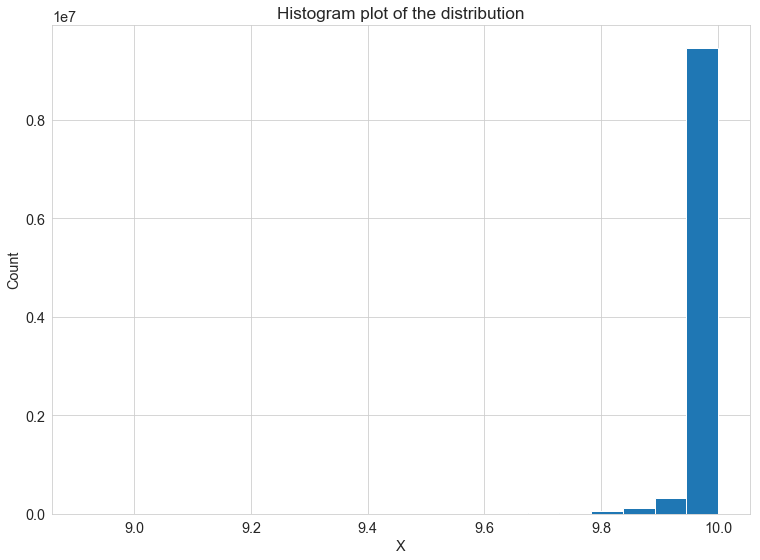

In [264]:
plt.hist(population, bins = 20)
plt.xlabel('X')
plt.ylabel('Count')
plt.title('Histogram plot of the distribution')

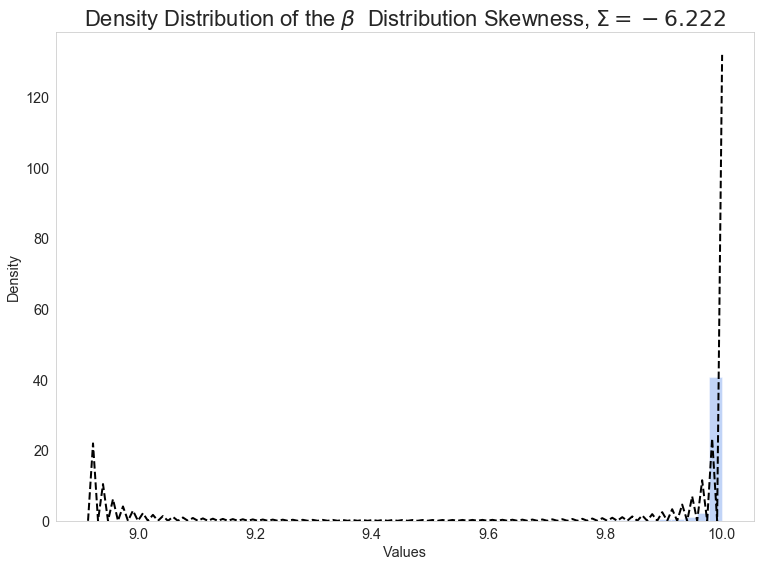

In [285]:
def plot_density(data, title, c):
    sns.distplot(data, color="cornflowerblue",
                            kde_kws = {'color':c, 
                           'linewidth':2, 'linestyle':'--'})
    plt.grid(False)
    plt.xlabel('Values')
    plt.ylabel('Density')
    plt.title(title, fontsize=22)
        
plot_density(population,r'Density Distribution of the $\beta$  Distribution '+ f'Skewness, $\Sigma = {round(skew,3)}$', 'black')

In [266]:
def sample_generator():
    my_lists = [[],[],[],[],[],[]]
    sample_sizes = [1, 3, 10, 100,1000,100000]
    for i,sample_size in enumerate(sample_sizes):
        for j in range(1,sample_size+1):
            sample_variant = random.choices(population, k=500)
            mean = sum(sample_variant)/len(sample_variant)
            my_lists[i].append(mean)
    return my_lists
        
my_lists = sample_generator()
x1,x2,x3,x4,x5,x6 = my_lists[0], my_lists[1], my_lists[2],my_lists[3],my_lists[4],my_lists[5]

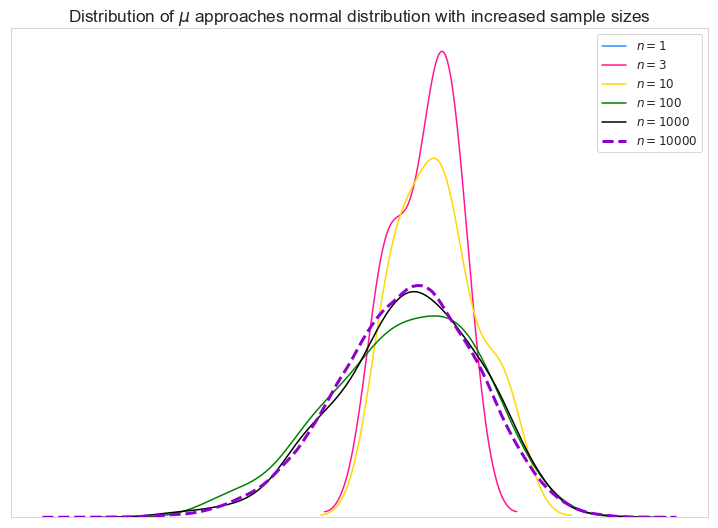

In [267]:
# Import data
x1,x2,x3,x4,x5,x6= my_lists[0], my_lists[1], my_lists[2],my_lists[3],my_lists[4],my_lists[5]
# plot
#fig, axes = plt.subplots(1, 3, figsize=(20, 10), sharey=True)
f, ax = plt.subplots(1)
#ax.set_xlim(left=0.8,right=1.1)
sns.distplot(x1 , color="dodgerblue", hist=False, label=f'$n = 1$')
sns.distplot(x2 , color="deeppink", hist=False, label=f'$n = 3$')
sns.distplot(x3 , color="gold", hist=False, label=f'$n = 10$')
sns.distplot(x4 , color="green", hist=False, label=f'$n = 100$')
sns.distplot(x5 , color="black", hist=False, label=f'$n = 1000$')
sns.distplot(x6 , color="black", hist=False, label=f'$n = 10000$',kde_kws = {'color':'#8e00ce', 
                           'linewidth':3, 'linestyle':'--'})

plt.title(f'Distribution of $\mu$ approaches normal distribution with increased sample sizes')
plt.yticks([])
plt.xticks([])
plt.legend()

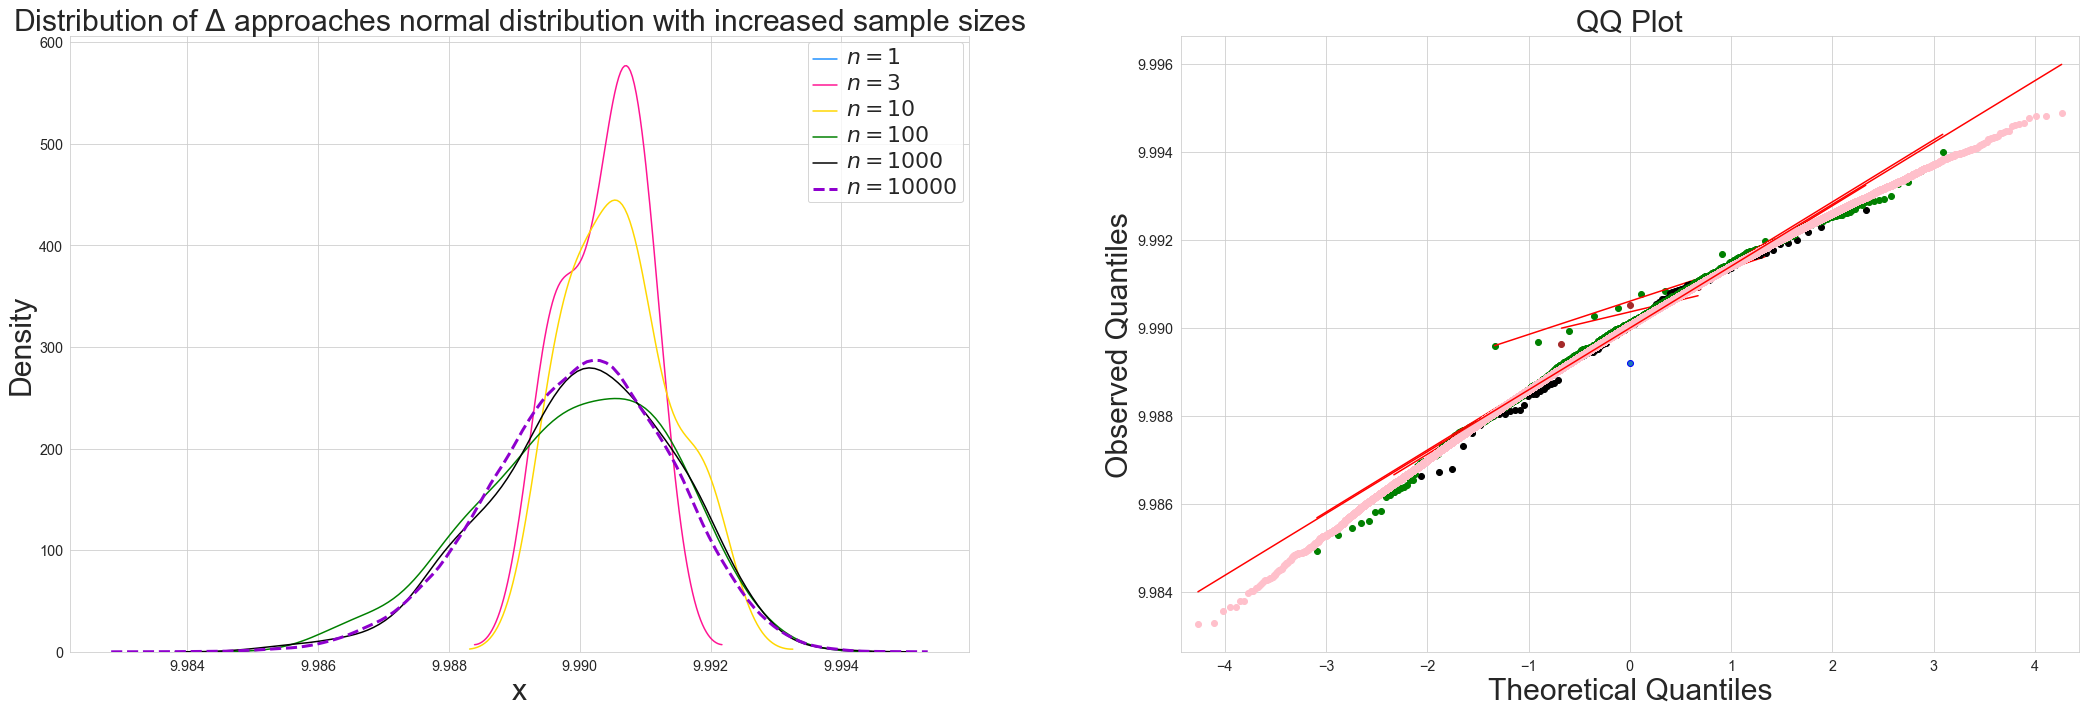

In [270]:
x1,x2,x3,x4,x5,x6 = my_lists[0], my_lists[1], my_lists[2],my_lists[3],my_lists[4],my_lists[5]
fig = plt.figure(figsize=(30, 10))
ax1 = plt.subplot(1, 2, 1)

ax1.set_title(f'Distribution of $\Delta$ approaches normal distribution with increased sample sizes',fontsize=30)
ax1.set_ylabel('Density', fontsize=30)
ax1.set_xlabel('x', fontsize=30)
#ax1.set_xlim(left=-4,right=4)
sns.distplot(x1 , color="dodgerblue", hist=False, label=f'$n = 1$')
sns.distplot(x2 , color="deeppink", hist=False, label=f'$n = 3$')
sns.distplot(x3 , color="gold", hist=False, label=f'$n = 10$')
sns.distplot(x4 , color="green", hist=False, label=f'$n = 100$')
sns.distplot(x5 , color="black", hist=False, label=f'$n = 1000$')
sns.distplot(x6 , color="black", hist=False, label=f'$n = 10000$',kde_kws = {'color':'#8e00ce', 
                           'linewidth':3, 'linestyle':'--'})

plt.setp(ax1.get_legend().get_texts(), fontsize='22')
ax2 = plt.subplot(1, 2, 2)
sm.qqplot(np.array(x1),ax=ax2,color='blue',line='s')
sm.qqplot(np.array(x2),ax=ax2,color='brown',line='s')
sm.qqplot(np.array(x3),ax=ax2,color='green',line='s')
sm.qqplot(np.array(x4),ax=ax2,color='black',line='s')
sm.qqplot(np.array(x5),ax=ax2,color='green',line='s')
sm.qqplot(np.array(x6),ax=ax2,color='pink',line='s')

ax2.get_lines()[0].set_markerfacecolor('C0')
ax2.set_title('QQ Plot', fontsize=30)
ax2.set_ylabel('Observed Quantiles', fontsize=30)
ax2.set_xlabel('Theoretical Quantiles', fontsize=30)

plt.subplots_adjust(hspace = 200)
plt.tight_layout()

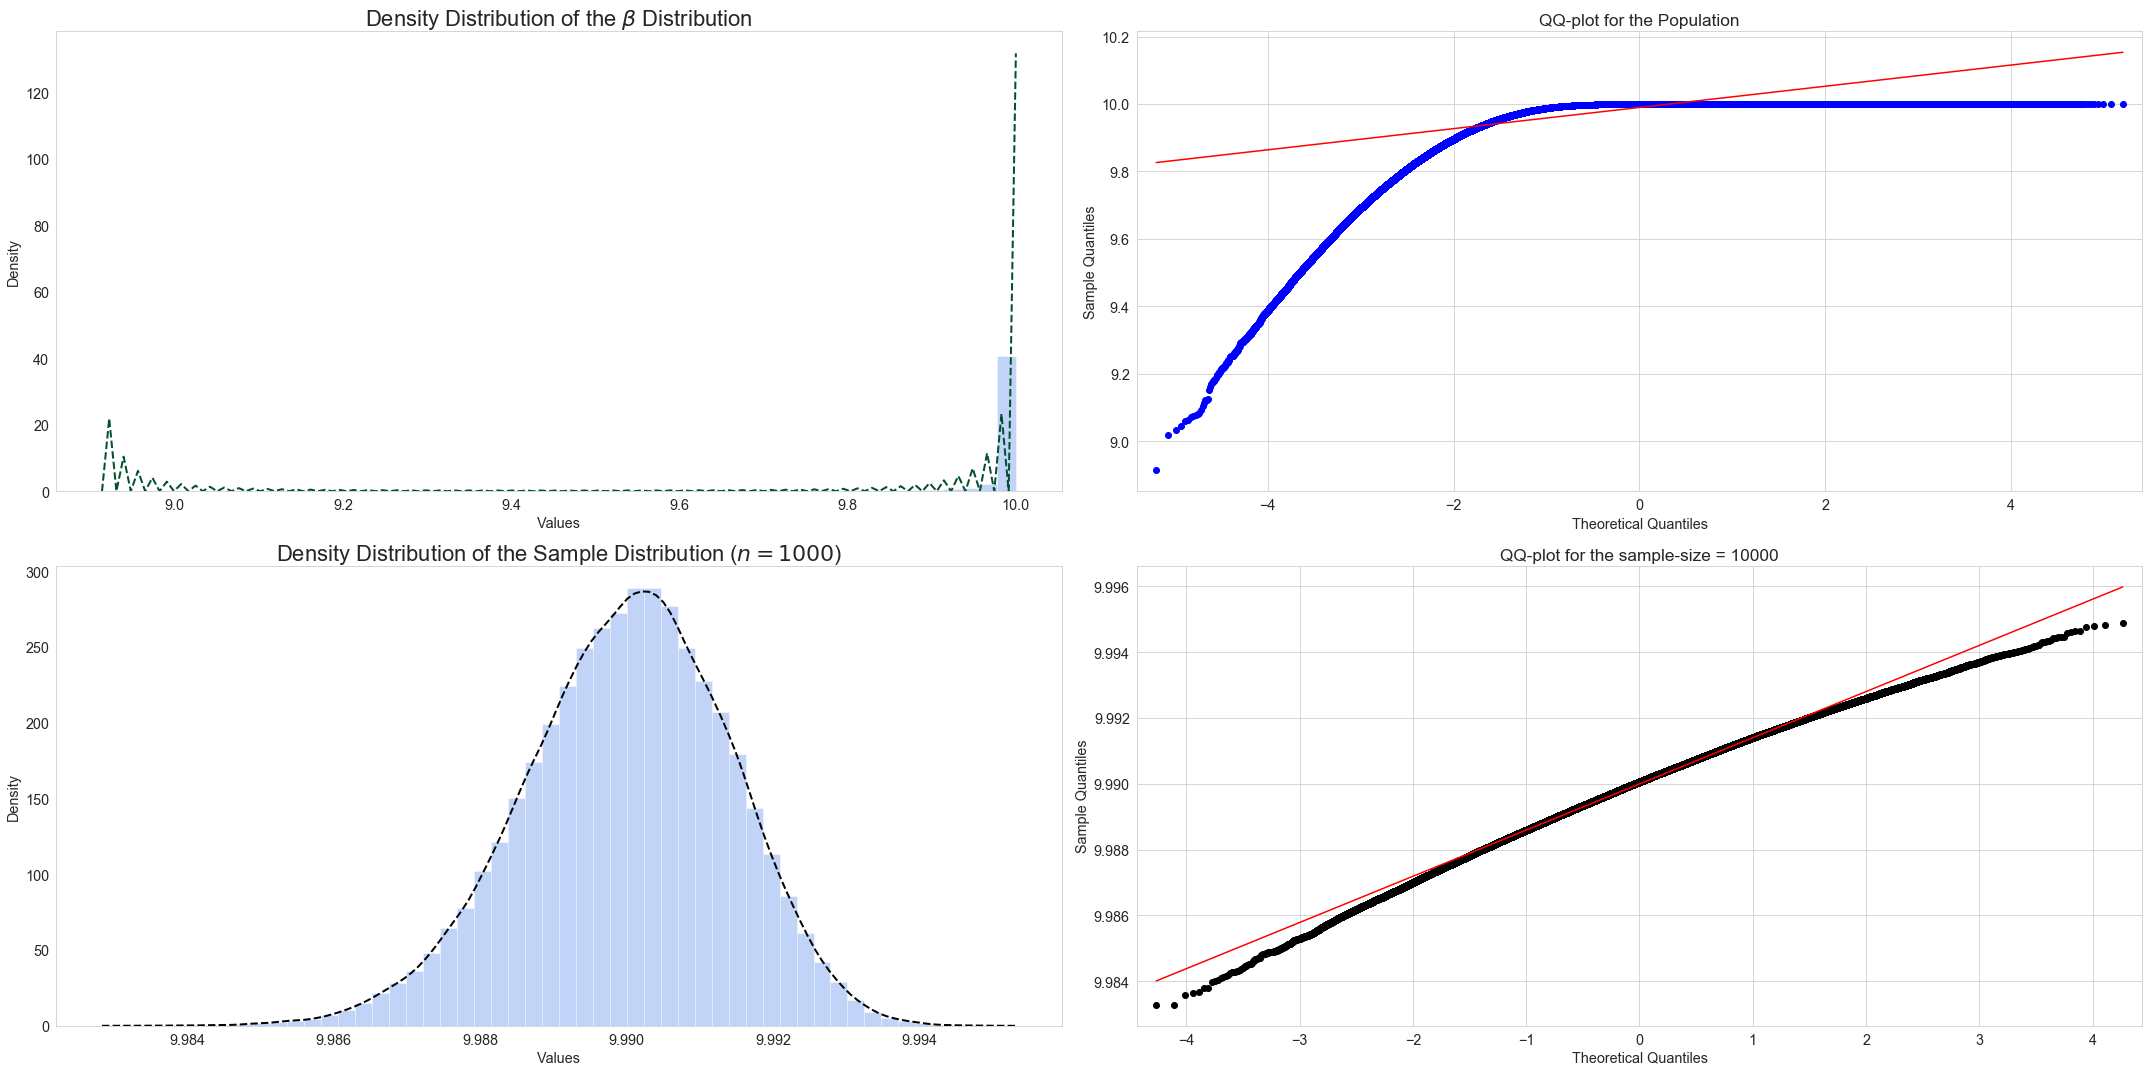

In [286]:
fig = plt.figure(figsize=(30, 15))

ax1 = plt.subplot(2, 2, 1)
plot_density(population,r'Density Distribution of the $\beta$ Distribution','#004F2D' )
ax2 = plt.subplot(2, 2, 2)
sm.qqplot(np.array(population), ax=ax2,color='blue',line='s')
plt.title('QQ-plot for the Population')
ax3 = plt.subplot(2, 2, 3)
plot_density(x6, f'Density Distribution of the Sample Distribution ($n=1000$)', "black")
ax4 = plt.subplot(2, 2, 4)
sm.qqplot(np.array(x6), ax =ax4, color='black',line='s')
plt.title('QQ-plot for the sample-size = 10000')

plt.tight_layout()



### Practical Application:

Metrics such as __revenue metrics__, generally tend to have a high skewness associated with it. A simple way to effectively reduce the skewness is to introduce capped methods. 

"General recommendation for minimum number of samples needed for the average $\Delta$ to approach normal distribution is $355s^{2}$ where $S$ is the skewness coefficient, for |skewness| > 1." - [Seven Rules of Thumb for Web Site Experimenters](https://www.exp-platform.com/Documents/2014%20experimentersRulesOfThumb.pdf)

# Effective way to reduce skewness:

It is not always easy to exercise the above method to minimum sample sizes. Limitations in available sample population may occur due to plenty of reasons such as:
- Conflict with other on-going experiments (leading to sample mismatch ratio (SRM) )
- Unavailabilibity of the recommended size for sample population due to limit in the number of consumers availability
- Unavailability to fully account for covariances for variant triggering, hence having to reduce sample size. 
- Other issues to account for such as residual effects, cannibalism and so on.
- Multiple variants A/B/C/D which could exhaust the number of available users. 

One of the effective methods of reducing skewness would be to introduce capping. It would effectively reduce the required number of sample sizes. 


### Example:
Example: Say you work at a company and then you want to do A/B/C/D test on revenue-per-user, where A is the Control and the others are different treatments. You look at your population with metric of interest and see there is the following distribution with the recommended sample size per variant. 

In [305]:
example_pop = np.random.beta(8, 0.01, size=10000000)*10
skew_example,_ = skew_kurtosis(example_pop)
min_samples = round(355 * (np.abs(skew_example))**2 )

Text(5, 10, 'Recommended variant size ($n =355\\Sigma^{2}) > $ 101821')

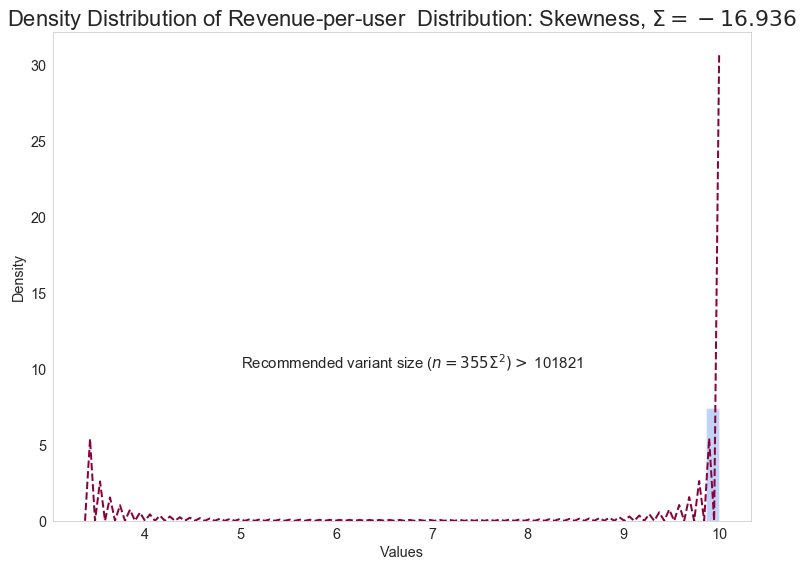

In [318]:

#plt.title(f'Recommended  Minimum sample required for each variant is {round(min_samples)}')
plot_density(example_pop,r'Density Distribution of Revenue-per-user  Distribution: '+ f'Skewness, $\Sigma = {round(skew_example,3)}$'
            , '#89023E')
plt.text(5,10, s = r'Recommended variant size ($n =355\Sigma^{2}) > $ ' + f'{min_samples}', fontsize=15)

As we can see the above dataset is highly skewed and the recommendation is minimum of 101271 for each variant. This is of concern as it would mean that we would need total of about 400,000 users. Let us cap the revenue per user at 10

Text(5, 10, 'Recommended variant size ($n =355\\Sigma^{2}) > $ 29456')

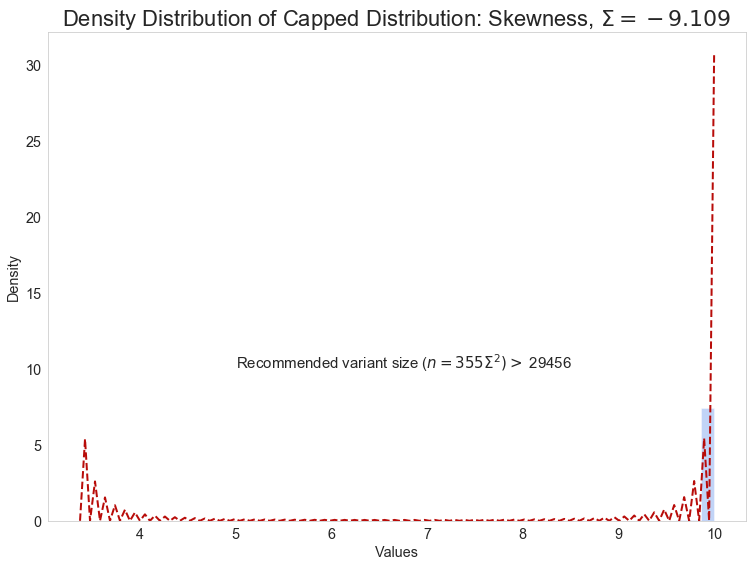

In [323]:
capped_pop = example_pop[example_pop<10]
skew_capped,_ = skew_kurtosis(capped_pop)
capped_samples = round(355 * (np.abs(skew_capped))**2 )
plot_density(example_pop,r'Density Distribution of Capped Distribution: '+ f'Skewness, $\Sigma = {round(skew_capped,3)}$'
            , '#B80C09')
plt.text(5,10, s = r'Recommended variant size ($n =355\Sigma^{2}) > $ ' + f'{capped_samples}', fontsize=15)

__We were effectively able to reduce the recommended number of each variant size by 73986 by reducing the skweness by capping the revenue-per-user to $10__

# References:

- [Power comparisons of Shapiro-Wilk, Kolmogorov-Smirnov, Liliefors and Anderson-Darling tets](https://www.researchgate.net/publication/267205556_Power_Comparisons_of_Shapiro-Wilk_Kolmogorov-Smirnov_Lilliefors_and_Anderson-Darling_Tests)


- [Goodness of fit Techniques -Agostino](https://www.google.com/books/edition/Goodness_of_Fit_Techniques/WLs6DwAAQBAJ?hl=en&gbpv=1&printsec=frontcover)

- [EDF Statistics for Goodness of Fit and Some Comparisons](https://www.jstor.org/stable/pdf/2286009.pdf?refreqid=excelsior%3Acb1eddf02a66e467e82f48c11291db36)

- [Approximating the Shapiro-Wilk W-test for non-normality](https://link.springer.com/article/10.1007%2FBF01891203)

- [Critical values tables for different tests](https://www.epa.gov/sites/production/files/2015-10/documents/monitoring_appendd_1997.pdf)

- [Shapiro-Wilk Expanded Test in Excel](https://www.real-statistics.com/tests-normality-and-symmetry/statistical-tests-normality-symmetry/shapiro-wilk-expanded-test/)

- [Seven Rules of Thumb for Web Site Experimenters](https://www.exp-platform.com/Documents/2014%20experimentersRulesOfThumb.pdf)